# Ford GoBike System Data
## by José María Prieto Pablos

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area with 2018 data and merged all the files in one master file.
>The target is to gather, clean and anlyse the data presenting the conclutions found in this slides



## **0. Preliminary Wrangling⇣**

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.image as mpimg
from PIL import Image

%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='onedork')
import glob
import os

from datetime import datetime
import calendar

import requests 
from geopy.distance import great_circle

### Data Gathering
Download all the 2018 fordgobike tripdata, the files are joined into a "MasterGoBike" Csv file that we treat as the master.

In [ ]:
#Only run once with files downloaded
path = os.getcwd()+"/files"
files = glob.glob(os.path.join(path, "*.csv"))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index = True)
df.to_csv('masterGoBike.csv', index = False)

In [3]:
df=pd.read_csv('masterGoBike.csv')

### Data Assessing

In [4]:
# visual assessment
df.head()
df.shape # There are 1.8M Registers
df.columns # 'duration_sec', 'start_time', 'end_time', 'start_station_id',
       #'start_station_name', 'start_station_latitude',
       #'start_station_longitude', 'end_station_id', 'end_station_name',
       #'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       #'bike_share_for_all_trip'

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'bike_share_for_all_trip'],
      dtype='object')

In [5]:
df.info()
#There seems to be well rounded

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         float64
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  int64  
 12  user_type                object 
 13  bike_share_for_all_trip  object 
dtypes: float64(6), int64(2), object(6)
memory usage: 199.1+ MB


In [6]:
#checking if there are duplicated elements
df.duplicated().sum() # There is 0 duplicated elements
#Checking if there are NAN elements
df.isnull().sum()#There are some NAN elements


duration_sec                   0
start_time                     0
end_time                       0
start_station_id           11771
start_station_name         11771
start_station_latitude         0
start_station_longitude        0
end_station_id             11771
end_station_name           11771
end_station_latitude           0
end_station_longitude          0
bike_id                        0
user_type                      0
bike_share_for_all_trip        0
dtype: int64

In [9]:
df[df["start_station_id"].isna()].sample()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,bike_share_for_all_trip
459584,217,2018-06-26 12:20:40.9350,2018-06-26 12:24:18.1340,NaN,NaN,37.4,-121.93,NaN,NaN,37.4,-121.93,4246,Subscriber,Yes


#### Assessment notes

    - Format of time has to be changed to datetime, currently object.
    - Format of some variables are to be changed to be use as categorical data: Shared (Yes/No),Type(cust,subs).
    - Format of IDs Object to str : start_station_id, end_station_id ,bike_id.
    - Nan data in 11771 rows in 4 variables: 
        - start_station_id
        - start_station_name
        - end_station_id
        - end_station_name.
    - Calculate some data based on inputs for categorical analysis: 
      A) Time meaningful (month,weekday,duration in minutes, am/pm, daytime) 
      B) Distance calculation (using geopy library)
    


### Data Cleaning

#### Performed cleaning actions
* #1 Format of time has to be changed to datetime, currently object
* #2 Format of IDs to categorical data. 'user_type','bike_share_for_all_trip'
* #3 Format of IDs to Str: 'start_station_id', 'end_station_id' ,'bike_id'
* #4 Adding month,weekday,hour and minute columns for start_time
* #5 Getting parts of the day column ('Late Night', 'Early Morning','Morning','Noon','Evening','Night')
* #6 Transforming duration of the trips to minutes for better interpretation
* #7 Calculate the distance(using geopy library)
* #8 Dropping some columns with redundant information


In [7]:
# to Ensure data integrity we work over the copy of the original dataset
df_clean = df.copy()

In [8]:
#1 Issue identified. Pass the data to datetime 
df_clean['start_time'] = pd.to_datetime(df_clean['start_time'])
df_clean['end_time'] = pd.to_datetime(df_clean['end_time'])
#2 Issue identified. type to categorical data
df_clean [['user_type','bike_share_for_all_trip']]= df_clean[['user_type','bike_share_for_all_trip']].astype('category')
#3 Issue identified. Format of IDs to Str: start_station_id, end_station_id ,bike_id
df_clean [['start_station_id', 'end_station_id' ,'bike_id']]= df_clean[['start_station_id', 'end_station_id' ,'bike_id']].astype(str)

In [9]:
#4 Adding month,weekday,hour and minute columns for start_time
df_clean['start_time_month'] = df_clean['start_time'].dt.month
s=[-1,1,4,7,10]
season_name = ['winter','spring','summer','fall']
df_clean['start_time_month_s'] = pd.cut(df_clean['start_time_month']-1, bins=s, labels=season_name)
df_clean['start_time_month_s']= df_clean['start_time_month_s'].fillna(value='winter')

m=[0,1,2,3,4,5,6,7,8,9,10,11,12]
month_name = ['Jan', 'Feb','Mar', 'Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
df_clean['start_time_month'] = pd.cut(df_clean['start_time_month'], bins=m, labels=month_name)

df_clean['start_time_day'] = df_clean['start_time'].dt.weekday

w=[-1,5,6]
week_part_name = ['working_days','Weekend']
df_clean['start_time_day_w'] = pd.cut(df_clean['start_time_day'], bins=w, labels=week_part_name)

d=[-1,0,1,2,3,4,5,6]
day_name = ['Mon', 'Tue','Wed', 'Thu','Fri','Sat','Sun']
df_clean['start_time_day'] = pd.cut(df_clean['start_time_day'], bins=d, labels=day_name)


df_clean['start_time_hour'] =df_clean['start_time'].dt.hour
df_clean['start_time_minute'] =df_clean['start_time'].dt.minute
#5 Getting parts of the day
b = [0,4,8,12,16,20,24]
part_day = ['Late Night', 'Early Morning','Morning','Noon','Evening','Night']
df_clean['start_time_part_day'] = pd.cut(df_clean['start_time_hour'], bins=b, labels=part_day)


In [10]:
#6 Transforming in minutes for better interpretation
df_clean['duration_min'] = (df_clean['duration_sec']/60).astype(int)


In [11]:
#Add column with distance in miles with "great_circle"
#Note - This takes a long time to be executed, few minutes in my computer 
df_clean['distance_M'] = df_clean.apply(lambda x: great_circle((x['start_station_latitude'], x['start_station_longitude']), 
                                                                (x['end_station_latitude'], x['end_station_longitude'])).miles, axis=1)

In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               datetime64[ns]
 2   end_time                 datetime64[ns]
 3   start_station_id         object        
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           object        
 8   end_station_name         object        
 9   end_station_latitude     float64       
 10  end_station_longitude    float64       
 11  bike_id                  object        
 12  user_type                category      
 13  bike_share_for_all_trip  category      
 14  start_time_month         category      
 15  start_time_month_s       category      
 16  start_time_day           category      
 17  start_time_day_w         ca

In [16]:
df_clean.sample(5) 

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bike_share_for_all_trip,start_time_month,start_time_month_s,start_time_day,start_time_day_w,start_time_hour,start_time_minute,start_time_part_day,duration_min,distance_M
1355664,804,2018-08-10 18:34:05.859,2018-08-10 18:47:30.596,90.0,Townsend St at 7th St,37.771058,-122.402717,5.0,Powell St BART Station (Market St at 5th St),37.783899,...,No,Ago,summer,Fri,working_days,18,34,Evening,13,0.940780
789158,501,2018-05-02 20:16:45.247,2018-05-02 20:25:06.482,202.0,Washington St at 8th St,37.800754,-122.274894,160.0,West Oakland BART Station,37.805318,...,No,May,spring,Wed,working_days,20,16,Evening,8,1.133438
1424010,450,2018-10-31 12:12:53.414,2018-10-31 12:20:23.695,77.0,11th St at Natoma St,37.773507,-122.416040,350.0,8th St at Brannan St,37.771431,...,No,Oct,fall,Wed,working_days,12,12,Morning,7,0.578058
1697970,640,2018-03-11 06:16:18.646,2018-03-11 06:26:59.390,214.0,Market St at Brockhurst St,37.823321,-122.275733,195.0,Bay Pl at Vernon St,37.812314,...,No,Mar,spring,Sun,Weekend,6,16,Early Morning,10,1.115618
974342,451,2018-01-20 12:51:32.807,2018-01-20 12:59:03.814,176.0,MacArthur BART Station,37.828410,-122.266315,189.0,Genoa St at 55th St,37.839649,...,No,Jan,winter,Sat,working_days,12,51,Morning,7,0.831366


In [17]:
df_clean.duration_min.mean()


13.796815081227287

In [18]:
df_clean.user_type.value_counts()

Subscriber    1583554
Customer       280167
Name: user_type, dtype: int64

In [19]:
df_clean.columns

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'bike_share_for_all_trip', 'start_time_month', 'start_time_month_s',
       'start_time_day', 'start_time_day_w', 'start_time_hour',
       'start_time_minute', 'start_time_part_day', 'duration_min',
       'distance_M'],
      dtype='object')

## Structure of the cleaned dataset

> Over 1.8M trips in the original dataset with 21 features. We keep the following after cleaning:

* **Timing (When)**
    * start_time (>start_time_month, start_time_day, start_time_hour, start_time_minute, start_time_part_day)
    * end_time
    * duration_sec (duration_min)
* **Ride (where)**
    * start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude (>distance_M)
    * start_station_id, start_station_name.
    * end_station_id, end_station_name.
* **Bike (How)**
    * bike_id
* **User (Who)**
    * user_type
    * bike_share_for_all_trip

## Main features of interest in this dataset:

> We'll focus on the time when the ride in order to understand better the patterns of usage of the service. We´ll analyze the type of users and the location related features to understand also how it is being used.
It seems that there is not anymore any user realted info such as age or gender, that could´ve help to enrich the analysis and customize decisions based on that.

### The features that can provide a better understanding the operation are the following:
>* duration_min
* start_time_month / start_time_day / start_time_part_day
* distance_M
* start_station_id / end_station_name
* user_type
* bikes_for_all


___________

## I. Univariate Exploration

> Since it is relevant for the operation to understand better when and where the trips are commencing, I will analyzing the **start_time** and **start_station** as singular variables with the univariante exploration.


## **1.When are the bikes being used? ⇣**

#### Number of bike trips per month
Usage seems to be more popular during the best weather season, specifically with the less rainy season, as it could be expected. 

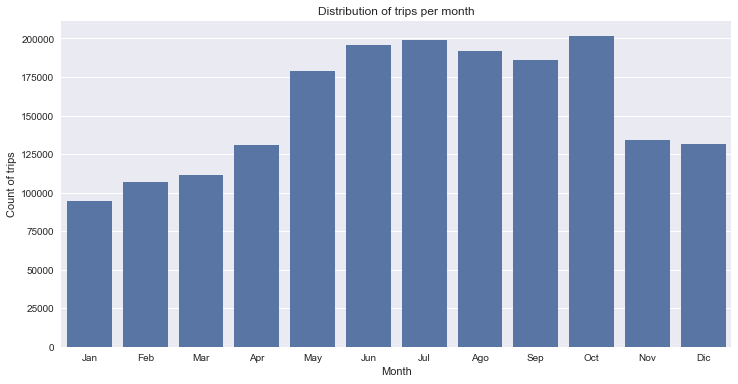

In [20]:
#Plotting the ocurrence of trips per month
sb.set(style="darkgrid")
fig = plt.figure(figsize = [12,6])
base_color = sb.color_palette()[0]
sb.countplot(data=df_clean, x='start_time_month', color=base_color)

plt.xlabel('Month')
plt.ylabel('Count of trips')
plt.title('Distribution of trips per month');
plt.show()

#plt.figure(figsize = (11,4))
#plt.rcParams["axes.grid"] = False
#plt.imshow(mpimg.imread('average-raindays-united-states-of-america-san-francisco.png'))


#### Rainy season and Temperature in San Francisco
Clear inverted correlation with usage of the service

>![Raindays in SFO](average-raindays-united-states-of-america-san-francisco.png)
>![Temp in SFO](average-temperature-united-states-of-america-san-francisco.png)


#### Count of trips aggregated by season:
Following the previous observation winter shows the moment of the year when occurrence is smaller and summer the highest.

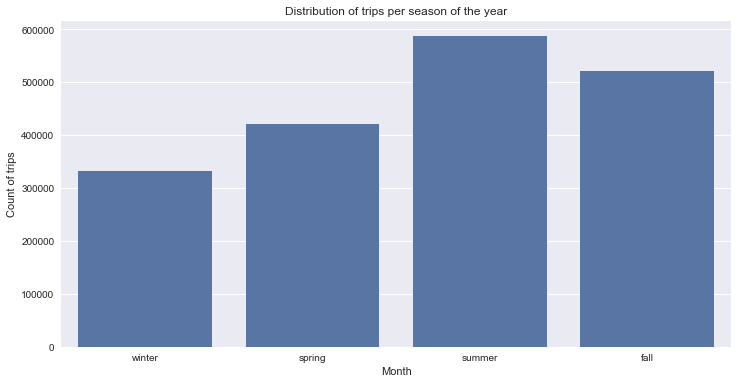

In [303]:
#Plotting the ocurrence of trips per season
sb.set(style="darkgrid")
fig = plt.figure(figsize = [12,6])
base_color = sb.color_palette()[0]
sb.countplot(data=df_clean, x='start_time_month_s', color=base_color)

plt.xlabel('Month')
plt.ylabel('Count of trips')
plt.title('Distribution of trips per season of the year');

### Notes
> Following the previous observation winter shows the moment of the year when occurrence is smaller
<br/>
**Question** ¿winter campaings, weather forecast on the apps?

#### Trips per day of the week
Working days shows higher number of bike trips, being Saturdays and Sundays at the bottom

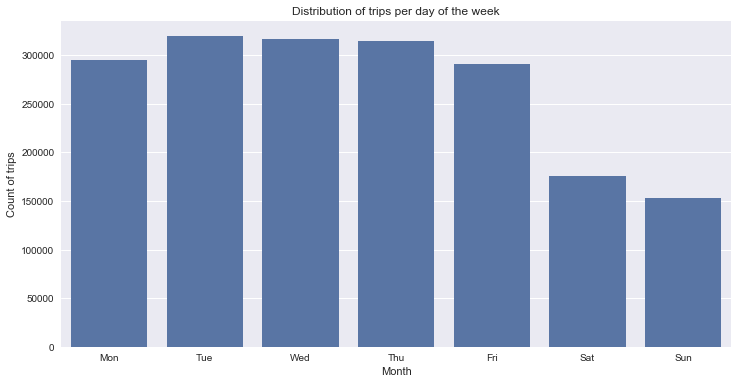

In [20]:
#Plotting the ocurrence of trips per day of the week
sb.set(style="darkgrid")
fig = plt.figure(figsize = [12,6])
base_color = sb.color_palette()[0]
sb.countplot(data=df_clean, x='start_time_day', color=base_color)

plt.xlabel('weekday')
plt.ylabel('Count of trips')
plt.title('Distribution of trips per day of the week');

### Notes
> half of the week shows higher number of bike trips, being Saturdays and Sundays at the bottom

#### Trips in working days vs weekends
Usage is massively higher during the working days

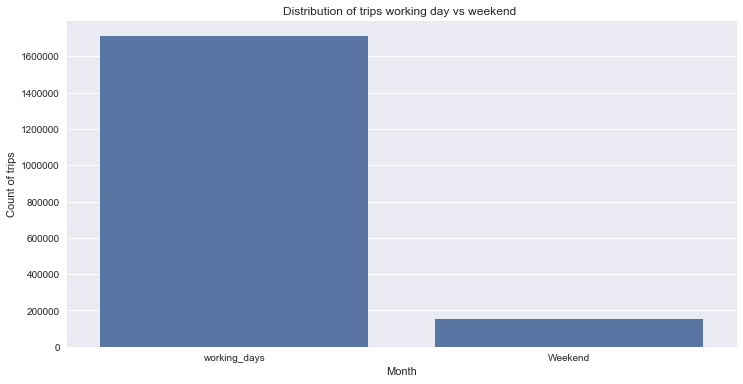

In [92]:
#Plotting the ocurrence of trips on weekdays or weekends
sb.set(style="darkgrid")
fig = plt.figure(figsize = [12,6])
base_color = sb.color_palette()[0]
sb.countplot(data=df_clean, x='start_time_day_w', color=base_color)

plt.xlabel('Month')
plt.ylabel('Count of trips')
plt.title('Distribution of trips working day vs weekend ');

### Notes
> Weekends are quite down compare with the distribution of the working days
<br/>**Question** Weekend 1/2 price? Weekend promotions? Communication actions for weekend usage ?

#### Trips per hour of the day
Clearly connected to commercial working hours 8am in and 5pm out.

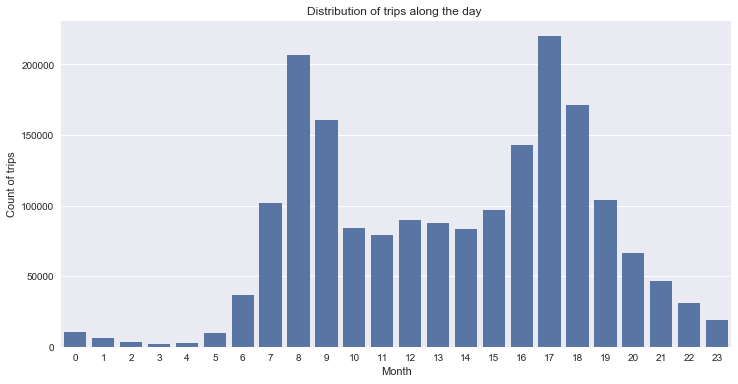

In [22]:
#Plotting the ocurrence of trips along the day hours
sb.set(style="darkgrid")
fig = plt.figure(figsize = [12,6])
base_color = sb.color_palette()[0]

sb.countplot(data=df_clean, x='start_time_hour', color=base_color)
plt.xlabel('Month')
plt.ylabel('Count of trips')
plt.title('Distribution of trips along the day ');




### Notes
> Clearly connected to commercial working hours 8am in and 5pm out
<br/>**Question** Lunch time offers? get a discount if you go to the restaurant with your bike?

#### Trips aggregated per part of the day
Aggregated, Mornings including early morning and evenings are more active times of the day

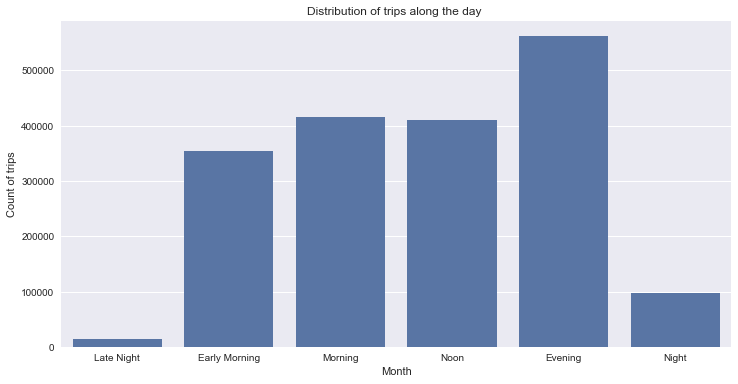

In [91]:
#Plotting the ocurrence of trips along the day parts
sb.set(style="darkgrid")
fig = plt.figure(figsize = [12,6])
base_color = sb.color_palette()[0]
ax = fig.add_axes([.125, .125, .775, .755])

sb.countplot(data = df_clean, x = 'start_time_part_day', color = base_color, ax = ax)

#sb.countplot(data=df_clean, x='start_time_part_day', color=base_color)
plt.xlabel('Month')
plt.ylabel('Count of trips')
plt.title('Distribution of trips along the day ');

### Notes
> in aggregated, evenings are more active than the rest of the day

### **Bikes are mainly used by commutters to go the office**
Looking at the above graphs it seems to be a clear pattern around the following timings:
- Weather, specifically rain has a big impact on usage.
- Summer is the busier time of the year.
- The service seems to be connected to working schedules, presumably people are it to go to the office.
- The 2 peak times of usage are connected to Office hours (8am and 5pm) with a valley in between, being the evening the preferred part of the day to bike.
- During the weekend the use drops considerably while during the working days the usage is similar, being monday slightly below.

## **2. How is people using the bikes?⇣**

#### Distribution of Distance and duration
- The bast majority of trips are under 3 Miles and tipically around 1 Mile, as it could be expected for a bike service
- Inline with the distance distributions, the majority is under 30mins and typically around 10 minutes


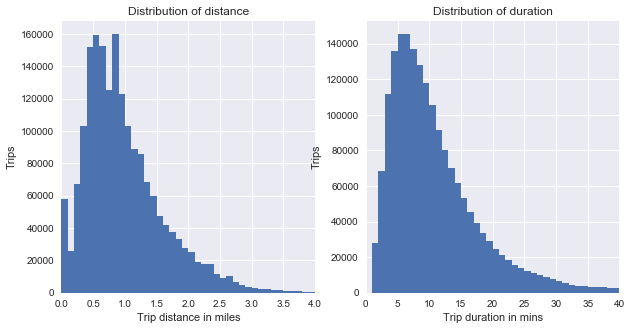

In [21]:
plt.figure(figsize = [10, 5]) # figure size for subplots

plt.subplot(1, 2, 1) # 1 row, 2 cols, subplot 1
bin_edges = np.arange(0, 6, 0.1)
plt.hist(data = df_clean, x = 'distance_M',bins = bin_edges, rwidth = 1);
plt.xlim(0, 4)
plt.xlabel('Trip distance in miles')
plt.ylabel('Trips')
plt.title('Distribution of distance');

plt.subplot(1, 2, 2) # 1 row, 2 cols, subplot 2
plt.xlim(0, 40)
bin_edges = np.arange(0, 1000, 1)
plt.hist(data = df_clean, x = 'duration_min', bins = bin_edges);
plt.xlabel('Trip duration in mins')
plt.ylabel('Trips')
plt.title('Distribution of duration');
#plt.xscale('log')
#plt.xlabel('log(values)')

In [47]:
print("Distance in Miles:")
print(df_clean.distance_M.describe()[[6,1]])
print("Duration in Minutes:")
print(df_clean.duration_min.describe()[[6,1]])

Distance in Miles:
75%     1.297085
mean    0.988559
Name: distance_M, dtype: float64
Duration in Minutes:
75%     14.000000
mean    13.796815
Name: duration_min, dtype: float64


In [50]:
print("Distance in Miles:")
print(df_clean.distance_M.quantile(.99))

Distance in Miles:
2.972063290180478


In [66]:
print("Duration in Mins:")
print(df_clean.duration_min.quantile(.99))

Distance in Miles:
92.0


### Notes
> - the bast majority of trips are under 3 Miles and tipically around 1 Mile, as it could be expected for a bike service
- inline with the distance distributions, the majority is under 30mins and typically around 10 minutes

#### Top 10 visited Start stations
- TOP start stations and End stations are quite similar, probably because people is using the service to go to the office and back from the office.
- It is also interesing to see that there are many stations, so probably people is commutting afterwards.


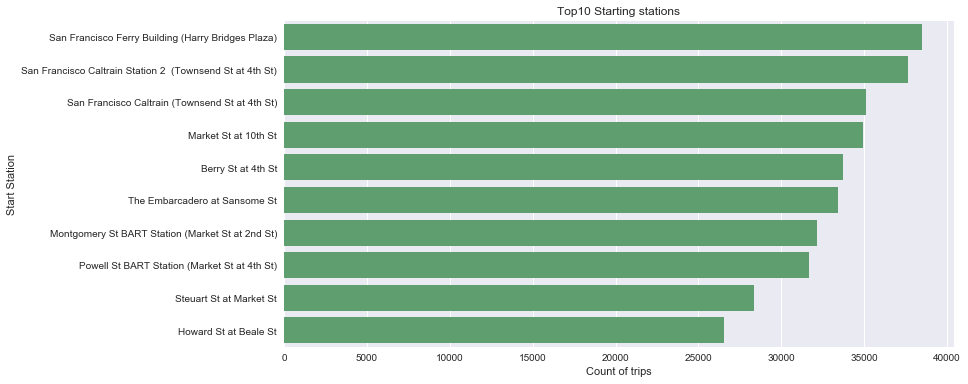

In [307]:
#Plotting Top 10 most populars start_station_name 
sb.set(style="darkgrid")
fig = plt.figure(figsize = [12,6])
base_color = sb.color_palette()[1]

sb.countplot(data=df_clean, y ='start_station_name', color=base_color,
              order=df_clean.start_station_name.value_counts().iloc[:10].index)
plt.xlabel('Count of trips')
plt.ylabel('Start Station')
plt.title('Top10 Starting stations');

#### Top 10 visited End stations

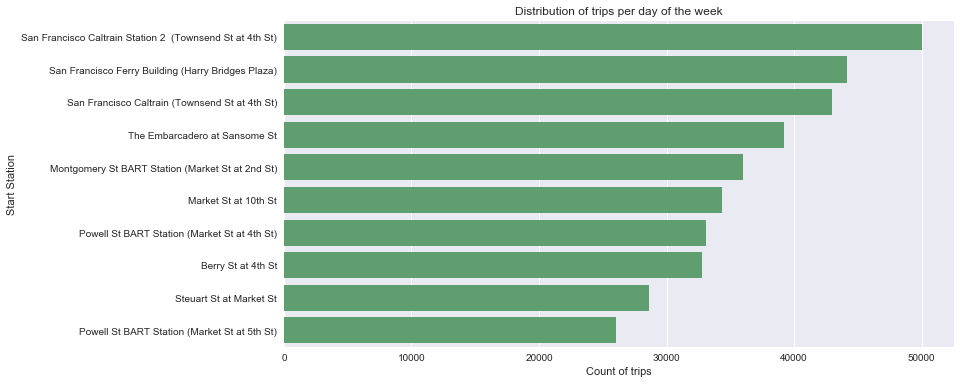

In [26]:
#Plotting most populars end_station_name
#Plotting Top 10 most populars start_station_name 
sb.set(style="darkgrid")
fig = plt.figure(figsize = [12,6])
base_color = sb.color_palette()[1]

sb.countplot(data=df_clean, y ='end_station_name', color=base_color,
              order=df_clean.end_station_name.value_counts().iloc[:10].index)
plt.xlabel('Count of trips')
plt.ylabel('End Station')
plt.title('Top10 End Stations');

### Notes
> TOP start stations and End stations are quite similar, probably because people is using the service to go to the office and back from the office.
<br/>It is also interesing to see that there are many stations, so probably people is commutting afterwards.
<br/>**Question** deploying more on the other popular commutting points? Making promotions in those stations?

## **Short trips for commutters**
Looking at the data plots, we can appreciate the following :
- People use the bikes for short distances between 0-3Miles and spend typically 10 minutes on the journey.
- There seems to be many people going and leaving the office, and commutting on train, ferry or Bus.


# Univariant Observations:
### Data observations: 
- The timing variable presents logical patterns of usage of the service like this, with bikes: Sensitivity with good weather. 
- Also it is mapped to what seems to be the main usage of the service: Transportation to/from work in the last few miles. 
- To observe the above I had to split the variables and extract meaning categorizations of the datetime variable 

### Insights: 
- Bikes are mainly used by commutters to go the office.
- Weather, specifically rain has a big impact on usage.
- Summer is the busier time of the year.
- The service seems to be connected to working schedules, presumably people are it to go to the office.
- The 2 peak times of usage are connected to Office hours (8am and 5pm) with a valley in between, being the evening the preferred part of the day to bike.
- During the weekend the use drops considerably while during the working days the usage is similar, being monday slightly below.

### Comments
- No major suprises so far on the investigation, data is clean and logical. It supports initial logical conclusions.

___________

## III. Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [27]:

Quantitative_vars = ['duration_min','distance_M']
categorical_vars = ['start_station_name','end_station_name','bike_id','user_type','bike_share_for_all_trip','start_time_month','start_time_month_s',
       'start_time_day', 'start_time_day_w', 'start_time_hour',
       'start_time_minute', 'start_time_part_day',]



In [157]:
df_clean.columns

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'bike_share_for_all_trip', 'start_time_month', 'start_time_month_s',
       'start_time_day', 'start_time_day_w', 'start_time_hour',
       'start_time_minute', 'start_time_part_day', 'duration_min',
       'distance_M'],
      dtype='object')

## **3.How usage varies depending on the type of user?⇣**


#### Distance in Miles vs user type:
The behavior or both type of users seems to be similar in average regarding the distance, being Customer prone to slightly longer trips

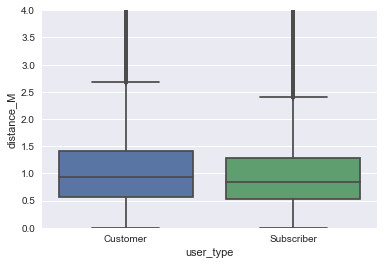

In [310]:
#sb.violinplot(x="user_type", y="distance_M", kind="violin", inner="quartile", data=df_clean)
sb.boxplot(x="user_type", y="distance_M", data=df_clean)
#plt.yscale('log')
plt.ylim(0, 4);
#sb.swarmplot(x="user_type", y="distance_M", color="k", size=3, data=df_clean, ax=g.ax);

> #### **Observations:**
- the behavior or both type of users seems to be similar in average regarding the distance, being Customer prone to slightly longer trips

#### Duration in minutes vs user type:
We can see that considering the similarities in distance, the duration on the trips presents more remarkable differences, we could consider that the "Subscriber" type is more in a hurry while the "Customer" type might be doing a more relaxing trip.

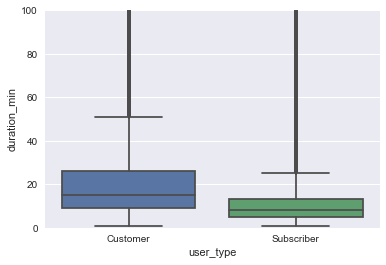

In [309]:
sb.boxplot(x="user_type", y="duration_min", data=df_clean)
#plt.yscale('log')
plt.ylim(0, 100);

>#### **Observations:**
- We can see that considering the similarities in distance, the duration on the trips presents more remarkable differences, we could consider that the "Subscriber" type is more in a hurry while the "Customer" type might be doing a more relaxing trip.
<br/>** Question** Sightseeing tips for Customers Users?

#### Sharing_bike vs user type:
Bike share for all trips are among subcribers only (as it is expected since the bike share for all is a subscription submodel for low income prople)

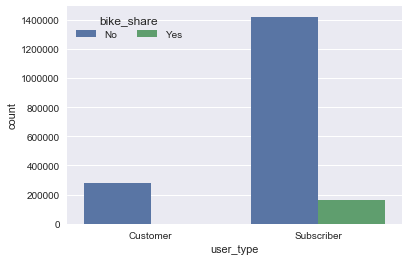

In [308]:
ax = sb.countplot(data = df_clean, x = 'user_type', hue = 'bike_share_for_all_trip')
ax.legend(loc = 2, ncol = 4, framealpha = 1, title = 'bike_share');

In [302]:
df_clean.query("bike_share_for_all_trip == 'Yes'").shape[0]/df_clean.shape[0]
#8,7% are Bikeforall
df_clean.query("user_type == 'Subscriber'").shape[0]/df_clean.shape[0] #84,9% Are Subs

df_clean.query("bike_share_for_all_trip == 'Yes'").shape[0]/df_clean.query("user_type == 'Subscriber'").shape[0] # 10.2% of subs are Bikesforall

0.10251308133476976

>#### **Observations:**
- Bike share for all trips are among subcribers only (as it is expected since the bike share for all is a subscription submodel for low income prople)


## **4.How usage changes along the week?⇣**


#### Distance in Miles vs day of the week for user type Customers:
Customer are clearly a more casual user, that even grows during the weekend.

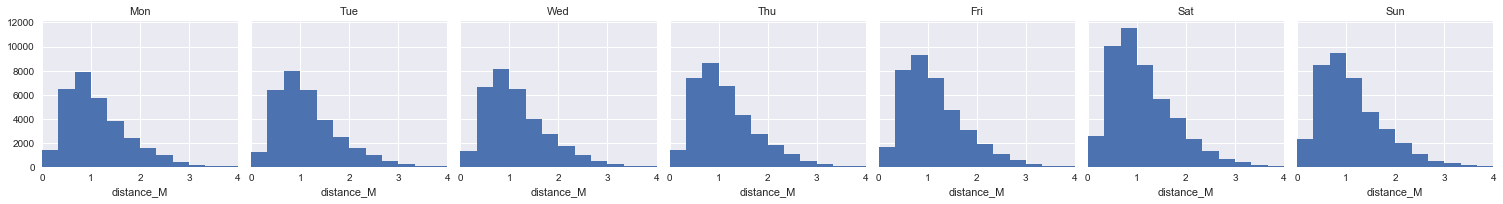

In [120]:
df_cust=df_clean.query('user_type == "Customer"')
bin_edges = np.arange(-3, df_cust['distance_M'].max()+1/3, 1/3)
g = sb.FacetGrid(data = df_cust, col = 'start_time_day')
g.map(plt.hist, "distance_M",bins = bin_edges).set(xlim=(0, 4))
g.set_titles('{col_name}');

#### Distance in Miles vs day of the week for user type Subscriber:
Subscribers drops to the half during the weekend and it a more utilitarian user of the service that goes to the office during the week.

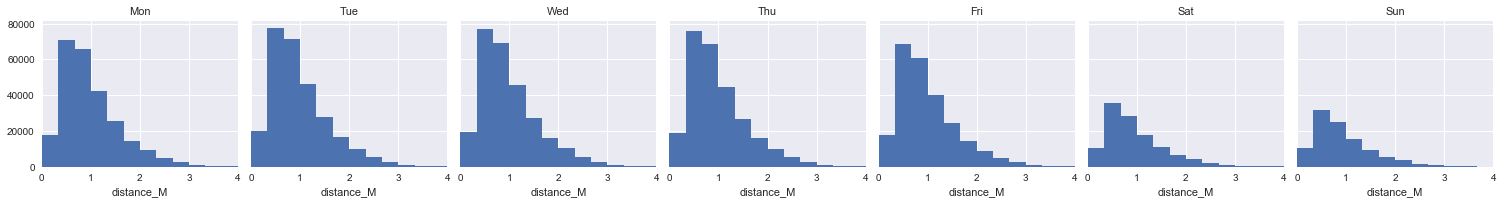

In [121]:
df_cust=df_clean.query('user_type == "Subscriber"')
bin_edges = np.arange(-3, df_cust['distance_M'].max()+1/3, 1/3)
g = sb.FacetGrid(data = df_cust, col = 'start_time_day')
g.map(plt.hist, "distance_M",bins = bin_edges).set(xlim=(0, 4))
g.set_titles('{col_name}');

>#### **Observations:**
- Subscribers drops to the half during the weekend while Customer even grows during the weekend.
<br/>** Question** Weekend pass for friends of Subscribers?

# Bivariant Observations:
### Customers vs Subscribers

> The 2 type of users have different patterns of usage, the type "Customer" is a minority compared with type "Subscriber". Customers use the service all days in similar patterns in terms of distance and number of trips, presenting with even higher numbers during the weekend, while the Subscriber drops to the half during the weekend.

### How the use the service?

> There is also impact on type of usage regarding the speed, it is clear that Subscriber is giving a more functional usage to the bike, sinc the time spend is much smaller than the Customer.

___________

## IV. Multivariate Exploration

> Following the type of user to usage investigation of the previous section, we anlyze how the 2 types of users behave in terms of part of the day along the year, considering the 4 seasons

## **5.How usage changes along the year for the 2 type of users?⇣**


#### Duration along the year per part of the day by user type
We can observe that the behaviour in terms of duration (the one that differs the most between Customers and Subscribers) tends to overlap mostly during the summer and less during the spring and Winter (more rainy seasons) when the trips seems to be faster.

In [183]:
#sb.catplot(x="start_time_part_day", y="duration_min", hue="user_type", kind="swarm", data=df_clean);
#plt.yscale('log')
#plt.ylim(0, 100)

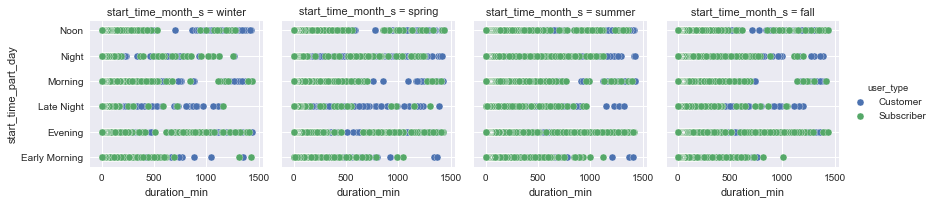

In [185]:
g = sb.FacetGrid(df_clean, col="start_time_month_s",  hue="user_type")
g = (g.map(plt.scatter, "duration_min", "start_time_part_day", edgecolor="w")
      .add_legend(""));

>#### **Observations:**
- We can observe that the behaviour in terms of duration (the one that differs the most between Customers and Subscribers) tends to overlap mostly during the summer and less during the spring and Winter (more rainy seasons) when the trips seems to be faster.


## **6. How the pattern of usage is affected along the year and along the week by different type of users ?⇣**


#### Speed: Distance vs Duration along the year
The relationship between distance and duration (speed) remains similar along the year

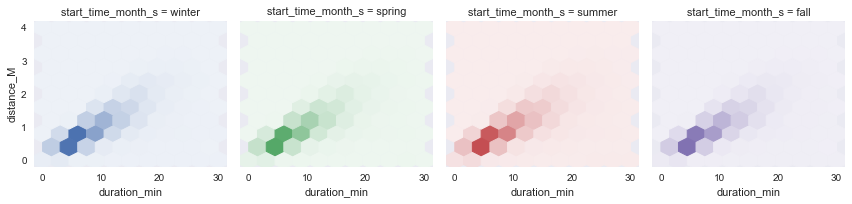

In [288]:
def hexbin(x, y, color, **kwargs):
    cmap = sb.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=10, cmap=cmap, **kwargs)

with sb.axes_style("dark"):
    g = sb.FacetGrid(df_clean, hue="start_time_month_s", col="start_time_month_s")
g.map(hexbin, "duration_min", "distance_M", extent=[0, 30, 0, 4]);
#sb.countplot(data=df_clean, x='start_time_hour', color=base_color)

>#### **Observations:**
- The relationship between distance and duration (speed) remains similar along the year


#### How it affects the weekend in regards to the pattern of use during the day?
We can observe that the usage patter doesn´t change much during the year, but we can also see that during the weekend the users are not making use as much during the early morning, since the usage is most probably connected with relazing activities compare with the office timetable that primes during the week which makes noon a more popular time during the weekend.

In [203]:
#cat_markers = [['Yes', 'o'],
#               ['No', 's']]

#for cat, marker in cat_markers:
#    df_cat = df_clean[df_clean['bike_share_for_all_trip'] == cat]
#    plt.scatter(data = df_cat, x = 'duration_min', y = 'distance_M', marker = marker)
#plt.legend(['Yes','No'])

In [125]:
#plt.scatter(data = df_clean, x = 'duration_min', y = 'duration_min', c = 'start_time_day')
#plt.colorbar()

In [204]:
#g = sb.FacetGrid(data = df_clean, hue = 'start_time_day_w', size = 5,
#                 palette = 'colorblind')
#g.map(plt.scatter, 'duration_min', 'distance_M')
#g.add_legend();

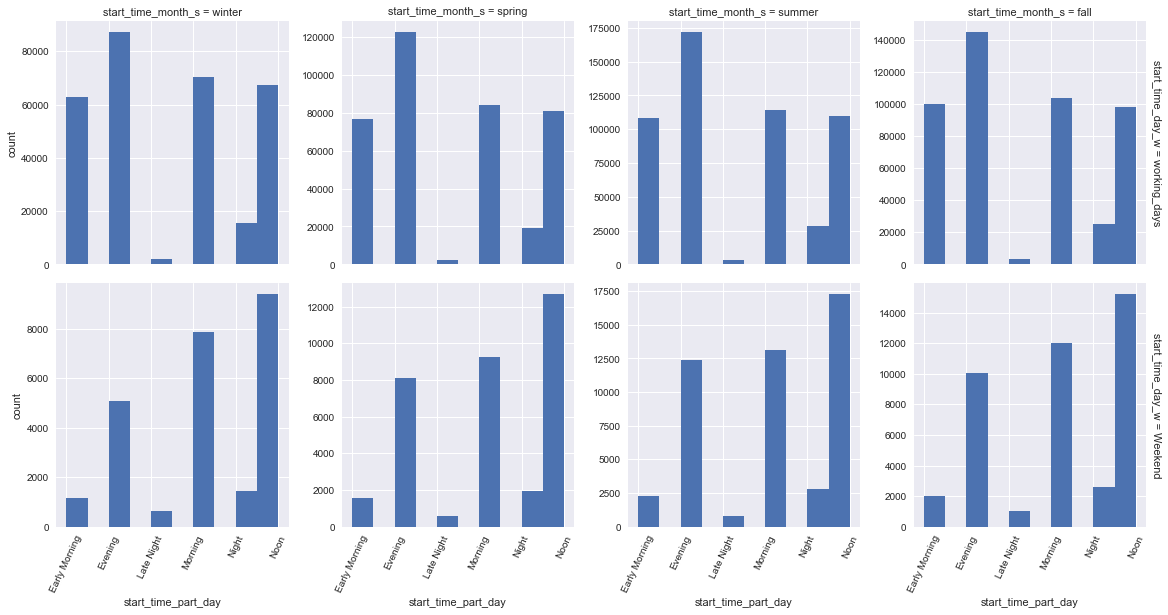

In [269]:

g = sb.FacetGrid(data = df_clean, col = 'start_time_month_s', row = 'start_time_day_w', size = 4,
                margin_titles = True, sharey=False)
#I use flexible y since I am more interested on the usage patter rather than the volumes
g.map(plt.hist, "start_time_part_day" )
g.set_axis_labels("start_time_part_day", "count")
g.set_titles('{col_name}')
g.set_xticklabels(rotation=65);

>#### **Observations:**
- We can observe that the usage patter doesn´t change much during the year, but we can also see that during the weekend the users are not making use as much during the early morning, since the usage is most probably connected with relazing activities compare with the office timetable that primes during the week which makes noon a more popular time during the weekend.


#### How is the pattern of usage per type of user?
Subs use the service primarly in the mornings and early mornings and then in the evenings. Meanwhile, Customers are slightly shifted to the half of the day and use the bikes mainly between mornings and evenings, being Noon the most popular time of the day for them.

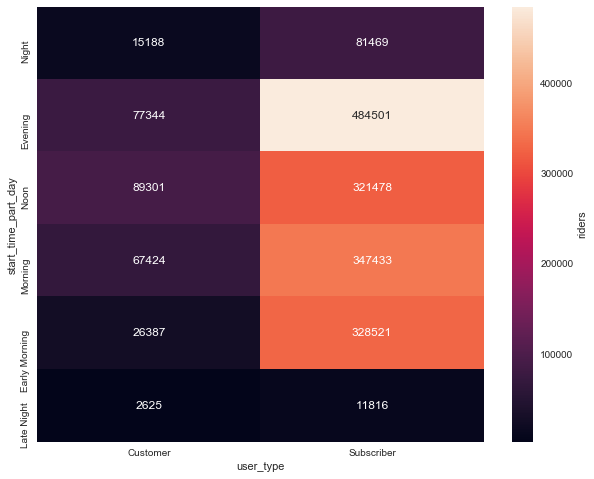

In [286]:
cat_means = df_clean.groupby(['user_type', 'start_time_part_day'])['user_type'].count()
cat_means = cat_means.reset_index(name = 'user_type_cnt')
cat_means = cat_means.pivot(index = 'start_time_part_day', columns = 'user_type',
                            values = 'user_type_cnt')
fig, ax = plt.subplots(figsize=(10,8))   
cat_means.sort_index(level=0, ascending=False, inplace=True)
sb.heatmap(cat_means, annot = True, fmt = '.0f',
           cbar_kws = {'label' : 'riders'});

>#### **Observations:**
- Subscribers use the service primarly in the mornings and early mornings and then in the evenings. Meanwhile, Customers are slightly shifted to the half of the day and use the bikes mainly between mornings and evenings, being Noon the most popular time of the day for them.


#### How Subscribers are using the bike along the week?
Subscribers are mainly using the bikes as work transportation (early mornings and mornings and the evenings). We can even observe that many leaves ealier on Fridays. During the weekend the traffic drops considerably and concentrates during the "Brunch" hours.

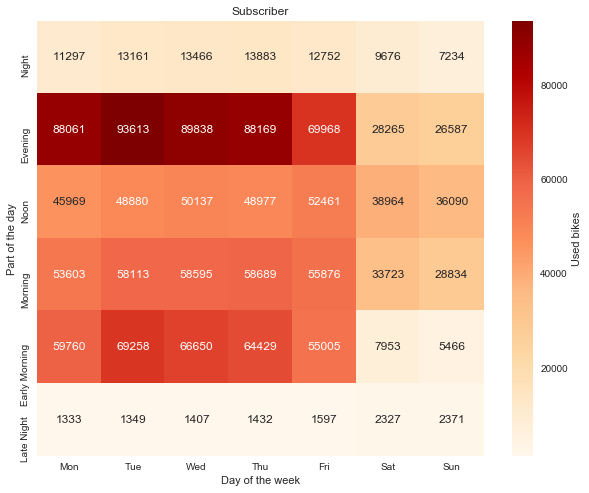

In [285]:
df_subs = df_clean.query('user_type == "Subscriber"').groupby(['start_time_part_day', 'start_time_day'])['bike_id'].size().reset_index();
df_subs = df_subs.pivot('start_time_part_day', 'start_time_day', 'bike_id')
df_subs.sort_index(level=0, ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10,8))   
hot_map = sb.heatmap(df_subs, annot=True,fmt='.0f', cbar_kws = {'label' : 'Used bikes'},cmap='OrRd')
plt.title("Subscriber")
plt.xlabel('Day of the week')
plt.ylabel('Part of the day')

plt.show();

>#### **Observations:**
- Subscribers as previously observed are mainly using the bikes during the week and quite aligned with office hours (early mornings and mornings and the evenings. We can even observe that many leaves ealier on Fridays. During the weekend the traffic drops considerably and concentrates during the "Brunch" hours

# Multivariant Observations:
### The Multivariant analysis reinforce the initial premise about the patter of usage of the service
The pattern is stable along the year, but on the weekends users are not making use as much during the early morning, since, it is most probably connected with more relaxing activities compare with the office timetable that primes during the week which makes noon a more popular time during the weekend.
There are some differences in terms of usage between Subs and Customers. Subs primarly in the mornings and early mornings and then in the evenings. Meanwhile, Customers are slightly shifted to the half of the day and use the bikes mainly between mornings and evenings, being Noon the most popular time of the day for them.

### Commutting service
We can see a very clear commutting behaviour in the Subscriber user base, which are the majority of the users. They tend to use the service to go to the office and it shows in the fact that weekends the traffic drops and the times for using the bikes delays to half of the day, while during the week it is go-back from office timetable

_________

# Results and Conclutions

GoBike service is a popular service that gives an environmental friendly mobility solution to people in 2 models, Subscription and one off payments. It also provides a discounted subscription for low income people. The majority of users are of the type subscriber and 10% of them are suscribed to the Bikes for all program.

The service seems to be connected to working schedules, presumably people go to the office with the bikes, there are 2 peak times of usage are 8am and 5pm with a valley in between, being the evening the preferred part of the day to bike. During the weekend the use drops considerably while during the working days the usage is similar, being monday slightly below. There seems to be many people going and leaving the office, and commutting on train, ferry or Bus considering the stations popularity as starting and finish stations. 
The typical user make less than 3 miles and spends around 10 minutes.
Being a bike service, the weather affects heavily the amount of users, primarily the appearence of rain reduces the usage, Summer is the busiest time of the year. 

# Recommendations:
- Considering the impact season, it could be interesiting to prepare some winter campaings, also, it could be interesing to connect some weather forecast on the apps so the users could know in advance if it is a good day or not. Also could be interesting to associate notifications on the app to the weather forecast. "Tomorrow is a good bike day, save some CO2 and strech your legs! Gobike awaits!"
- Considering the drop on the weekends, there could be possible to release some Weekend 1/2 price in company or other sort of weekend promotions or at the minimum, some Communication actions to encourage some weekend usage, including leisure activities or associated discounts in the areas of coverage
- Considering the Lunch valleym it could be interesting to make some Lunch time special offers, or get a discount if you go to the restaurant with your bike for instance.
- Considering the popularity of the Stations, for the operation and good provision of bikes, it could be interesting to deploy more on the other popular commutting points also, could be interesing to make some discovery promotions in the stations and trains/buses 

# Thanks!